In [1]:
!cp -r "../input/t1images/exactT1/exactT1"   "T1-images"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as Adam
import nibabel as nib
import skimage.transform as skTrans
import torchvision


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    "DEVICE":device,
    "GENLR":3e-4,
    "DISCLR":3e-4,
    "EPOCHS":100,
    "ROOT_T1":"./T1_slices/",
    "ROOT_T2":"./T2_slices/",
    "TRANSFORMS":torchvision.transforms.ToTensor(),
    "BATCH_SIZE":5
}

In [4]:
!cp  "../input/t1images/test.csv" "/kaggle/working/"
!cp  "../input/t1images/train.csv" "/kaggle/working/"


In [5]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=config["DEVICE"])
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


In [7]:
class Generator(nn.Module):
    def __init__(self, img_channels=1, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [8]:
genT2  = Generator(img_channels=1, num_residuals=9).to("cuda")
genT1  = Generator(img_channels=1, num_residuals=9).to("cuda")


In [9]:
opt_gen = torch.optim.Adam(
        list(genT2.parameters()) + list(genT1.parameters()),
        lr=config["GENLR"],
        betas=(0.5, 0.999),
    )

In [10]:
load_checkpoint(
          "../input/updatedcheckpointssdp/genT2.pth (1).tar"  , genT2, opt_gen, config["GENLR"],
        )

=> Loading checkpoint


In [22]:
img   =  nib.load("../input/t1images/exactT1/exactT1/crossmoda2021_ldn_100_ceT1.nii").get_fdata()
img = skTrans.resize(img, (200,200,120), order=1, preserve_range=True)
img = torch.tensor(img).cuda().float()
img = img.view(1,200,200,120)
T2_slices = []
for i in range(30):
    ith_slice = img[0, :, :, i].view(1,200,200).cuda()
    T2_slices.append(genT2(ith_slice))
    

### Visualizing input T1 slices(T1-MRI)

In [42]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
fig,axs = plt.subplots(2,5,dpi=300,figsize=(50,50))
plot = 10
for i in range(2):
    for j in range(5):
        axs[i][j].imshow(img[0,:,:,plot].cpu().view(200,200).detach().numpy(),cmap='gray')
        axs[i][j].set_title('source T1 slice')
        plot += 1
        plt.subplots_adjust()
plt.savefig("Input T1 image.jpg")

### Visualizing output T2 slices(Synthetic MRI T2)

In [43]:
matplotlib.rcParams.update({'font.size': 25})
fig,axs = plt.subplots(2,5,dpi=300,figsize=(50,50))
plot = 10
for i in range(2):
    for j in range(5):
        axs[i][j].imshow(T2_slices[plot].cpu().view(200,200).detach().numpy(),cmap='gray')
        axs[i][j].set_title('generated T2 slice' )
        plot += 1
        plt.subplots_adjust()
plt.savefig("Generated T2 image.jpg")

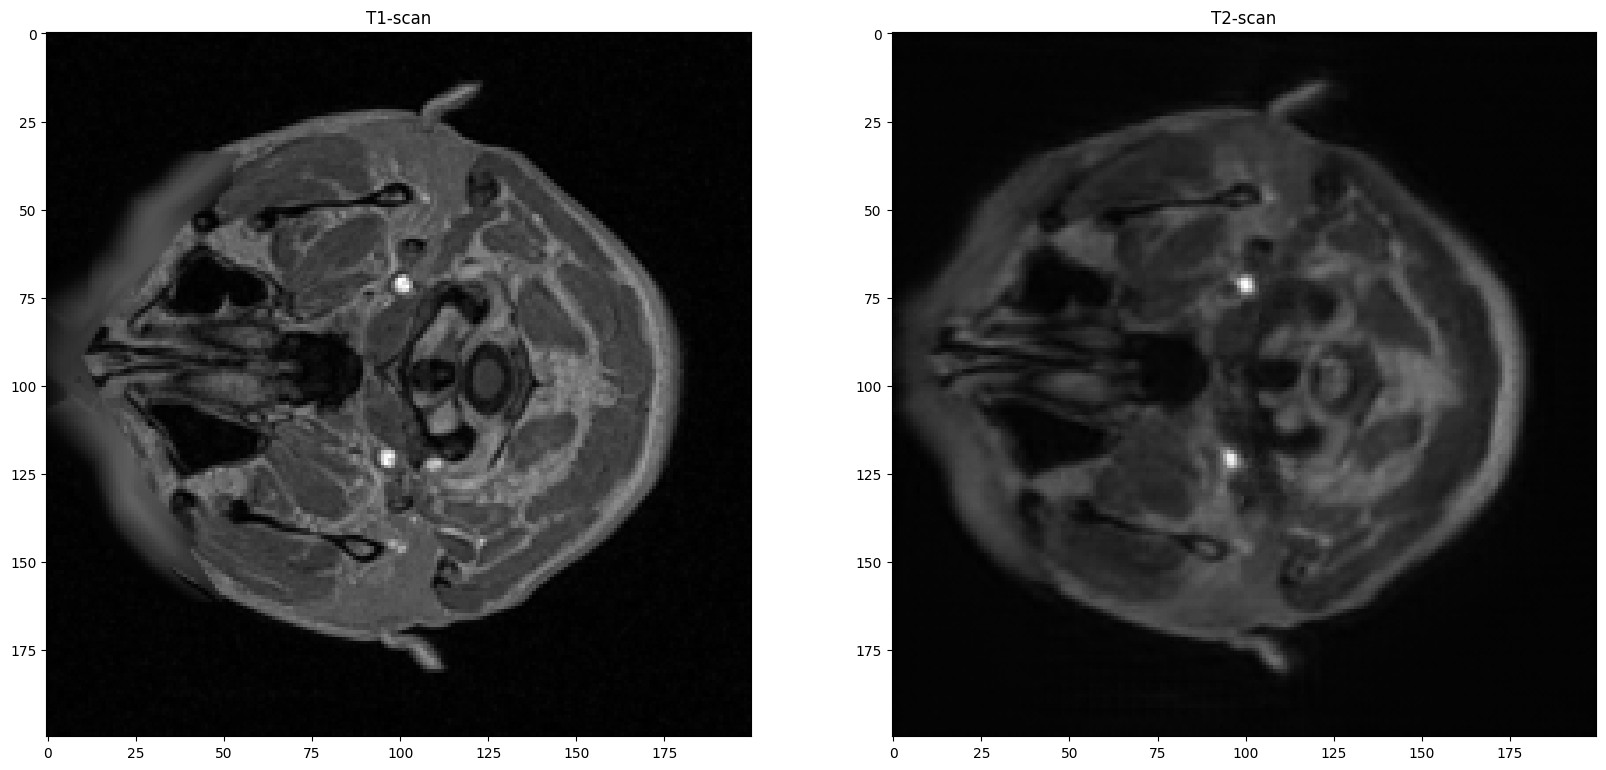

In [41]:
matplotlib.rcParams.update({'font.size': 10})
T1_slice = img[0, :, :, plot].cpu().view(200,200)
T2_slice = T2_slices[plot].cpu().view(200,200).detach().numpy()
fig,axs = plt.subplots(1,2,figsize=(20,20),dpi=100)
axs[0].imshow(T1_slice,cmap='gray')
axs[0].set_title("T1-scan")
axs[1].imshow(T2_slice,cmap='gray')
axs[1].set_title("T2-scan")
plt.show()

### Calculating psnr score between T1-image and synthetic T2 image. Positive psnr score indicates that the content of T1-MRI was preserved during generation of T2-MRI

In [50]:
from torchmetrics import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio()
psnr_score = psnr(torch.tensor(T2_slice).view(1,1,200,200),T1_slice.view(1,1,200,200))
print("Psnr score :-  " + str(psnr_score.numpy()))

Psnr score :-  13.478409
